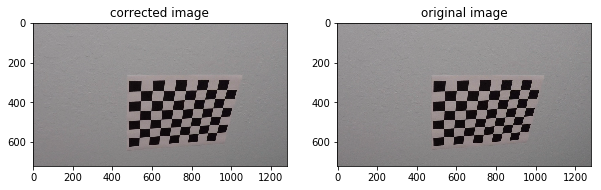

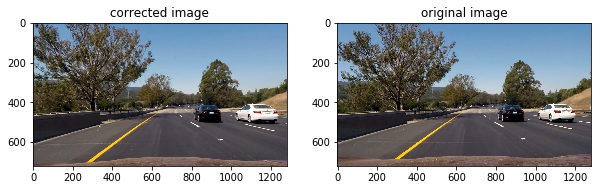

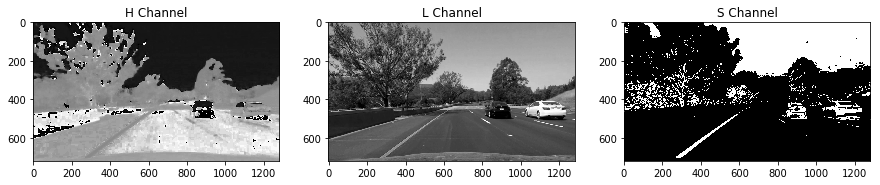

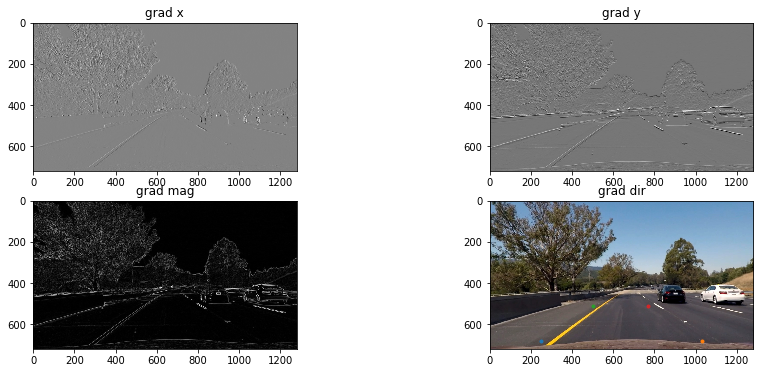

(720, 1280, 3)
440.142087427 m 389.113868483 m


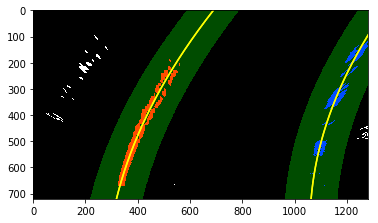

In [26]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt
import My_Functions as fnc

## Calibration
The Code below reads the images of the chessboard from the calibration file and estimates the calibration parameters including the calibtation matrix and the distorsion coefficients.

In [2]:
# Camera Calibration
calib_file = 'camera_cal/'
calib_img = os.listdir(calib_file)

nx = 9
ny = 6

image_points = []
object_points = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for image_name in calib_img:
    
    image = cv2.imread(calib_file + image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)
        
ret, mtx, dist, rvecs, tvects = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

## Image correction
The next code cell undistorts an example image from the chessborad.

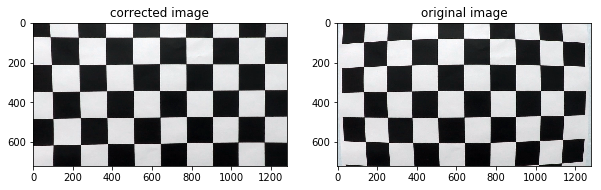

In [4]:
# undistort two example images:
img = cv2.imread(calib_file + calib_img[0])
dst = cv2.undistort(img, mtx, dist,None, mtx)

fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(dst)
axs[0].set_title('corrected image')
axs[1].imshow(img)
axs[1].set_title('original image')

fig.savefig('output_images/corrected_test_image.jpg', bbox_inches = 'tight')

# Line Detection Pipe Line

After obtaining the camera calibration parameters the lane detection pipline will be implemented step by step. First each step of the algorithm will be explaned in the next following code cells, and at the end all these steps will be abstracted into a function make the processing easier.

## 1. Correcting the original images from the camera

The first step is to correct the distorsions in the images obtained from the camera. The camera calibration parameters were computed in the previous section, and the image correction can be performed as follows.

In [11]:
# Select one of the images from the test images folder to start implementing advanced lane finding method
test_images_file = "test_images/"
test_images = os.listdir(test_images_file)

image_name = test_images_file + test_images[0]
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [12]:
# Undistord the selected test image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

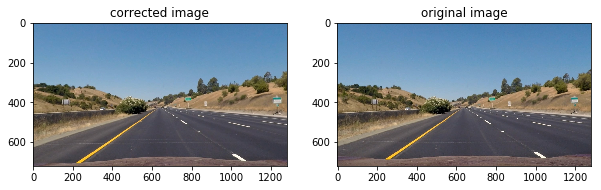

In [13]:
fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(undist_image)
axs[0].set_title('corrected image')
axs[1].imshow(image)
axs[1].set_title('original image')

fig.savefig("output_images/road_image_corrected.jpg", bbox_inches = 'tight')

## 2.Color Threshold

After applying the correction for distorsion a color threshold is applied to the images to keep the lane lines while discarding the most of the other pixels in the image that are not associated with lane lines.

The original images are in RGB color space. However, the HLS color space can do a better job especially when the road texture is varying or shadows are perestnt in the scene. Thefore the images will be transformed to the HLS color space, and the threshold will be applied on the S channel.

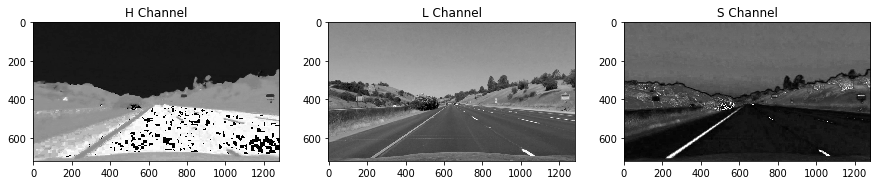

In [14]:
# Color Threshold on HLS(Hue, Lightness, saturation) images 
HLS_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2HLS)

H_channel = HLS_img[:,:,0]
L_channel = HLS_img[:,:,1]
S_channel = HLS_img[:,:,2]

fig, axs = plt.subplots(1,3, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(H_channel, cmap = 'gray')
axs[0].set_title('H Channel')

axs[1].imshow(L_channel, cmap = 'gray')
axs[1].set_title("L Channel")

axs[2].imshow(S_channel, cmap = 'gray')
axs[2].set_title('S Channel')

fig.savefig("output_images/HLS.jpg", bbox_inches = 'tight')

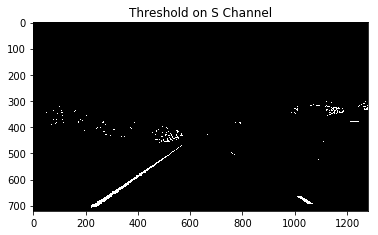

In [17]:
# Threshold the S channel. The threshold values should be tuned carefully.
thresh = (150, 255)
S_binary = np.zeros_like(S_channel)
S_binary[(S_channel>thresh[0]) & (S_channel<=thresh[1])] = 1

fig = plt.figure()
plt.imshow(S_binary, cmap = 'gray')
plt.title('Threshold on S Channel')

fig.savefig("output_images/threshold_S.jpg", bbox_inches = 'tight')

## 3. Gradient Threshold

Color space threshold can be combined with gradient threshold to obtain a more robust pipeline. First the the RGB images will be conveted to gray scale, and then the gradient will be computed in $x$ and $y$ direction.

The amplitude of the gradient and the direction of the gradient vectors can be also obtained.

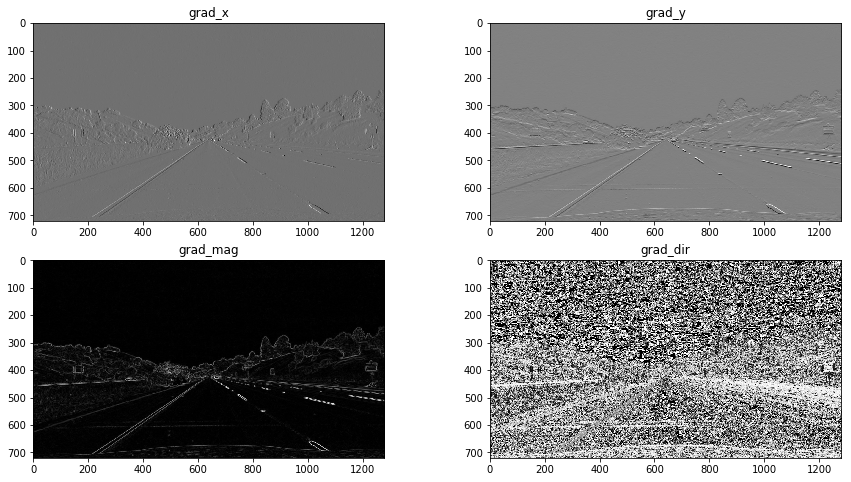

In [22]:
# Gradiend
gray_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_dir = np.arctan2(np.abs(grad_y),np.abs(grad_x))

fig, axs = plt.subplots(2,2, figsize = (15,8))
axs = axs.ravel()

axs[0].imshow(grad_x, cmap = 'gray')
axs[0]. set_title("grad_x")

axs[1].imshow(grad_y, cmap = 'gray')
axs[1]. set_title("grad_y")


axs[2].imshow(grad_mag, cmap = 'gray')
axs[2]. set_title("grad_mag")

axs[3].imshow(grad_dir, cmap = 'gray')
axs[3]. set_title("grad_dir")

fig.savefig("output_images/gradient.jpg", bbox_inches = 'tight')

In the My_Functions.py file the gradient threshold function is implemented. This function takes the RGB image and the threshold bounds as its inputs and generates a binary image based on the thresholds. The code cell below shows how this functions works.

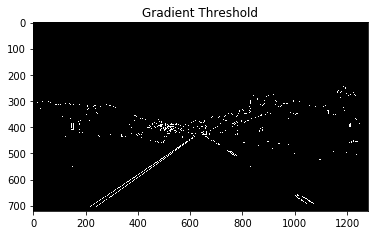

In [31]:
thresh_x = (30, 255)
thresh_y = (200, 255)
thresh_m = (60, 255)
thresh_d = (0.35, 1.57)

grad_thr = fnc.grad_thresh(undist_image, thresh_x, thresh_y, thresh_m, thresh_d)

fig = plt.figure()
plt.imshow(grad_thr, cmap = 'gray')
plt.title("Gradient Threshold")

fig.savefig('output_images/gradient_thr.jpg', bbox_inches = 'tight')

## 4. Combining the gradient threshold and color threshold
As mentioned earlier the thresholds should be combined inorder to obtain a better lane detection pipeline. The code cell below combines the two binary images from gradient threshold and color threshold.

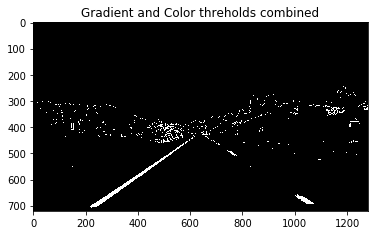

In [34]:
combined_thr = fnc.combine_thresholds(grad_thr, S_binary)

plt.imshow(combined_thr, cmap = 'gray')
plt.title('Gradient and Color threholds combined')